In [1]:
import os
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random
from tqdm import tqdm

from skimage import io, transform
from sklearn.model_selection import train_test_split
from sklearn.metrics import  accuracy_score
from sklearn.preprocessing import LabelEncoder

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
import torch.optim as optim
from torch.autograd import Variable
from PIL import Image
import torchvision
from torchvision import models,transforms

from Dataloaders.HAM10000Dataset import HAM10000Dataset
from functions import normalization, Model_functions

import time

import random
from PIL import Image
import cv2

In [2]:
data = pd.read_csv('data_enum.csv')
data = data.sample(frac=1)
data.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,dup_les,image_path,dx_cat
34,HAM_0000699,ISIC_0031575,nv,follow_up,50,male,lower extremity,False,HAM10000_images_part_2/nv/ISIC_0031575.jpg,1
9193,HAM_0005492,ISIC_0032138,df,histo,35,female,lower extremity,False,HAM10000_images_part_2/df/ISIC_0032138.jpg,2
20405,HAM_0000286,ISIC_0029099,vasc,consensus,70,female,abdomen,False,HAM10000_images_part_1/vasc/ISIC_0029099.jpg,4
4859,HAM_0006987,ISIC_0027649,bkl,histo,85,female,upper extremity,False,HAM10000_images_part_1/bkl/ISIC_0027649.jpg,0
17088,HAM_0000358,ISIC_0026976,mel,histo,60,male,back,False,HAM10000_images_part_1/mel/ISIC_0026976.jpg,3


# Preprocessing

**Normalize function**

In [3]:
img_h, img_w = 224, 224

In [4]:
# norm_means, norm_std = compute_img_mean_std(data['image_path'],img_h,img_w)

In [5]:
norm_means = [0.77148203, 0.55764165, 0.58345652]
norm_std = [0.12655577, 0.14245141, 0.15189891]

**Data Augmentation and normalization**

**Resize the data as 244X244 because most pretrainned models are that size**

In [6]:
# define the transformation of the train images.
transform = transforms.Compose([transforms.Resize((img_h,img_w)),transforms.RandomHorizontalFlip(),
                                      transforms.RandomVerticalFlip(),transforms.RandomRotation(20),
                                      transforms.ColorJitter(brightness=0.1, contrast=0.1, hue=0.1),
                                        transforms.ToTensor(), transforms.Normalize(norm_means, norm_std)])
# define the transformation of the val and test images.
val_test_transform = transforms.Compose([transforms.Resize((img_h,img_w)), transforms.ToTensor(),
                                        transforms.Normalize(norm_means, norm_std)])

In [7]:
data.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,dup_les,image_path,dx_cat
34,HAM_0000699,ISIC_0031575,nv,follow_up,50,male,lower extremity,False,HAM10000_images_part_2/nv/ISIC_0031575.jpg,1
9193,HAM_0005492,ISIC_0032138,df,histo,35,female,lower extremity,False,HAM10000_images_part_2/df/ISIC_0032138.jpg,2
20405,HAM_0000286,ISIC_0029099,vasc,consensus,70,female,abdomen,False,HAM10000_images_part_1/vasc/ISIC_0029099.jpg,4
4859,HAM_0006987,ISIC_0027649,bkl,histo,85,female,upper extremity,False,HAM10000_images_part_1/bkl/ISIC_0027649.jpg,0
17088,HAM_0000358,ISIC_0026976,mel,histo,60,male,back,False,HAM10000_images_part_1/mel/ISIC_0026976.jpg,3


**Data Loading**

In [8]:
train_val_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

train_data, val_data = train_test_split(train_val_data, test_size=0.5, random_state=42)

train_dataset = HAM10000Dataset(train_data, transform=transform)
val_dataset = HAM10000Dataset(val_data, transform=transform)
test_dataset = HAM10000Dataset(test_data, transform=transform)

In [9]:
batch_size = 64
num_workers = 4

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_loader = DataLoader(val_dataset, batch_size=batch_size, num_workers=num_workers)
test_loader = DataLoader(test_dataset, batch_size=batch_size, num_workers=num_workers)

print('Data len Train:', len(train_dataset), 'Val:', len(val_dataset), 'Test:', len(test_dataset))

Data len Train: 12362 Val: 12362 Test: 6181


**Batch check**

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


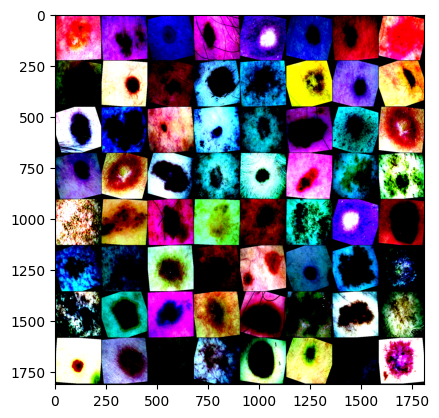

Labels:  tensor([2, 1, 4, 1, 2, 1, 1, 5, 2, 4, 4, 3, 5, 2, 1, 1, 3, 3, 1, 5, 2, 1, 2, 2,
        4, 2, 3, 2, 0, 1, 0, 3, 6, 1, 1, 6, 1, 0, 2, 4, 6, 0, 2, 1, 4, 4, 3, 2,
        5, 3, 4, 2, 1, 3, 6, 6, 4, 2, 4, 6, 0, 1, 3, 2])


In [10]:
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get a batch of training data
dataiter = iter(train_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))
print('Labels: ', labels) 

# Make the custom model

In [11]:
num_classes = 7

In [12]:
class CNNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Sequential(
        nn.Conv2d(3, 16, kernel_size=(3,3), padding=1),
        nn.BatchNorm2d(16),            
        nn.ReLU(),            
        nn.MaxPool2d(kernel_size=2,stride=2))
        self.layer2 = nn.Sequential(
        nn.Conv2d(16, 32, kernel_size=(3,3), padding=1),
        nn.BatchNorm2d(32),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,stride=2))
        self.layer3 = nn.Sequential(
        nn.Conv2d(32, 64, kernel_size=(3,3), padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,stride=2))
        self.layer4 = nn.Sequential(
        nn.Conv2d(64, 128, kernel_size=(3,3), padding=1),
        nn.BatchNorm2d(128),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,stride=2))

        self.fc1 = nn.Linear(128 * 14 * 14, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, num_classes)  

    def forward(self, x):
        x = x.view(-1, 3, img_h, img_w)
        out1 = self.layer1(x)
        out2 = self.layer2(out1)
        out3 = self.layer3(out2)
        out4 = self.layer4(out3)

        out = out4.view(out4.size(0), -1) #makes them flat
        out = F.relu(self.fc1(out))
        out = F.relu(self.fc2(out))
        out = self.fc3(out)
        return out

CNN_model = CNNet()

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

Using device: cuda


In [14]:
CNN_model = CNN_model.to(device)
input_size = (3, 224, 224)
summary(CNN_model, input_size, device=device.type)

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 16, 112, 112]        --
|    └─Conv2d: 2-1                       [-1, 16, 224, 224]        448
|    └─BatchNorm2d: 2-2                  [-1, 16, 224, 224]        32
|    └─ReLU: 2-3                         [-1, 16, 224, 224]        --
|    └─MaxPool2d: 2-4                    [-1, 16, 112, 112]        --
├─Sequential: 1-2                        [-1, 32, 56, 56]          --
|    └─Conv2d: 2-5                       [-1, 32, 112, 112]        4,640
|    └─BatchNorm2d: 2-6                  [-1, 32, 112, 112]        64
|    └─ReLU: 2-7                         [-1, 32, 112, 112]        --
|    └─MaxPool2d: 2-8                    [-1, 32, 56, 56]          --
├─Sequential: 1-3                        [-1, 64, 28, 28]          --
|    └─Conv2d: 2-9                       [-1, 64, 56, 56]          18,496
|    └─BatchNorm2d: 2-10                 [-1, 64, 56, 56]          128
|    └

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 16, 112, 112]        --
|    └─Conv2d: 2-1                       [-1, 16, 224, 224]        448
|    └─BatchNorm2d: 2-2                  [-1, 16, 224, 224]        32
|    └─ReLU: 2-3                         [-1, 16, 224, 224]        --
|    └─MaxPool2d: 2-4                    [-1, 16, 112, 112]        --
├─Sequential: 1-2                        [-1, 32, 56, 56]          --
|    └─Conv2d: 2-5                       [-1, 32, 112, 112]        4,640
|    └─BatchNorm2d: 2-6                  [-1, 32, 112, 112]        64
|    └─ReLU: 2-7                         [-1, 32, 112, 112]        --
|    └─MaxPool2d: 2-8                    [-1, 32, 56, 56]          --
├─Sequential: 1-3                        [-1, 64, 28, 28]          --
|    └─Conv2d: 2-9                       [-1, 64, 56, 56]          18,496
|    └─BatchNorm2d: 2-10                 [-1, 64, 56, 56]          128
|    └

In [15]:
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(CNN_model.parameters(), lr=1e-3)

**Fit the model using Validation set for the best model selection**

In [16]:
start_time = time.time()

In [17]:
epochs = 25
patience = 3
model_filename = 'CNN_model.pth'
model = CNN_model
CNN_model_fitted, total_loss_train, total_loss_val, total_acc_train, total_acc_val = Model_functions.train_and_validate_model(
                        model, train_loader, val_loader,test_loader, criterion,patience, optimizer, device, epochs, model_filename)

  4%|▍         | 1/25 [00:50<20:12, 50.50s/it]

Epoch 1
Training Loss: 1.646431740411778 
Training Accuracy: 40.13104675618832%
Validation Loss: 1.1915401078991055 
Validation Accuracy: 56.43099822035269%
Validation Loss Decreased(inf--->1.191540) 
Saving The Model


  8%|▊         | 2/25 [01:40<19:12, 50.12s/it]

Epoch 2
Training Loss: 1.0727997495956028 
Training Accuracy: 60.11972172787575%
Validation Loss: 0.9205769847348794 
Validation Accuracy: 65.29687752790811%
Validation Loss Decreased(1.191540--->0.920577) 
Saving The Model


 12%|█▏        | 3/25 [02:29<18:17, 49.89s/it]

Epoch 3
Training Loss: 0.8822716127351388 
Training Accuracy: 67.46481151917166%
Validation Loss: 0.7667101466471387 
Validation Accuracy: 70.78142695356739%
Validation Loss Decreased(0.920577--->0.766710) 
Saving The Model


 16%|█▌        | 4/25 [03:19<17:27, 49.87s/it]

Epoch 4
Training Loss: 0.7538383727528385 
Training Accuracy: 71.7925901957612%
Validation Loss: 0.6955433093088189 
Validation Accuracy: 74.18702475327616%
Validation Loss Decreased(0.766710--->0.695543) 
Saving The Model


 20%|██        | 5/25 [04:09<16:39, 49.97s/it]

Epoch 5
Training Loss: 0.6702393075240027 
Training Accuracy: 75.26290244297039%
Validation Loss: 0.5906540937337679 
Validation Accuracy: 78.15887396861349%
Validation Loss Decreased(0.695543--->0.590654) 
Saving The Model


 24%|██▍       | 6/25 [04:58<15:43, 49.66s/it]

Epoch 6
Training Loss: 0.58601522645385 
Training Accuracy: 78.15887396861349%
Validation Loss: 0.5935873028236566 
Validation Accuracy: 77.22051447985763%


 28%|██▊       | 7/25 [05:49<14:57, 49.88s/it]

Epoch 7
Training Loss: 0.527899027177968 
Training Accuracy: 80.37534379550235%
Validation Loss: 0.5100405290722847 
Validation Accuracy: 81.119559941757%
Validation Loss Decreased(0.590654--->0.510041) 
Saving The Model


 32%|███▏      | 8/25 [06:39<14:09, 50.00s/it]

Epoch 8
Training Loss: 0.5057820688510678 
Training Accuracy: 81.28134606050801%
Validation Loss: 0.4392884306840061 
Validation Accuracy: 83.84565604271154%
Validation Loss Decreased(0.510041--->0.439288) 
Saving The Model


 36%|███▌      | 9/25 [07:29<13:19, 49.98s/it]

Epoch 9
Training Loss: 0.43581237759172303 
Training Accuracy: 83.77285228927359%
Validation Loss: 0.38388793731165916 
Validation Accuracy: 86.08639378741304%
Validation Loss Decreased(0.439288--->0.383888) 
Saving The Model


 40%|████      | 10/25 [08:20<12:35, 50.36s/it]

Epoch 10
Training Loss: 0.42737324497441653 
Training Accuracy: 84.92153373240576%
Validation Loss: 0.33163528520729124 
Validation Accuracy: 88.18961333117619%
Validation Loss Decreased(0.383888--->0.331635) 
Saving The Model


 44%|████▍     | 11/25 [09:12<11:49, 50.68s/it]

Epoch 11
Training Loss: 0.37064329742156354 
Training Accuracy: 86.31289435366446%
Validation Loss: 0.4377567821864 
Validation Accuracy: 83.70813784177318%


 48%|████▊     | 12/25 [10:02<10:57, 50.59s/it]

Epoch 12
Training Loss: 0.344396818006776 
Training Accuracy: 87.599093997735%
Validation Loss: 0.31306735748789977 
Validation Accuracy: 89.26549102087041%
Validation Loss Decreased(0.331635--->0.313067) 
Saving The Model


 52%|█████▏    | 13/25 [10:51<10:02, 50.23s/it]

Epoch 13
Training Loss: 0.32936792259978265 
Training Accuracy: 88.47273903899045%
Validation Loss: 0.3531060463451233 
Validation Accuracy: 87.43730787898399%


 56%|█████▌    | 14/25 [11:41<09:10, 50.08s/it]

Epoch 14
Training Loss: 0.32722334582934676 
Training Accuracy: 88.47273903899045%
Validation Loss: 0.2816810952211471 
Validation Accuracy: 90.09868953243812%
Validation Loss Decreased(0.313067--->0.281681) 
Saving The Model


 60%|██████    | 15/25 [12:30<08:18, 49.81s/it]

Epoch 15
Training Loss: 0.2833507101713997 
Training Accuracy: 89.83174243649894%
Validation Loss: 0.28780513629317284 
Validation Accuracy: 90.04206439087527%


 64%|██████▍   | 16/25 [13:20<07:27, 49.69s/it]

Epoch 16
Training Loss: 0.2669957608138163 
Training Accuracy: 90.68920886587931%
Validation Loss: 0.32347190295605316 
Validation Accuracy: 88.79631127649247%


 68%|██████▊   | 17/25 [14:09<06:36, 49.62s/it]

Epoch 17
Training Loss: 0.2516783697088969 
Training Accuracy: 91.34444264682091%
Validation Loss: 0.23430791305205256 
Validation Accuracy: 91.65183627244782%
Validation Loss Decreased(0.281681--->0.234308) 
Saving The Model


 72%|███████▏  | 18/25 [14:58<05:46, 49.48s/it]

Epoch 18
Training Loss: 0.23023801101083607 
Training Accuracy: 92.080569487138%
Validation Loss: 0.31846774930192023 
Validation Accuracy: 88.62643585180392%


 76%|███████▌  | 19/25 [15:48<04:56, 49.48s/it]

Epoch 19
Training Loss: 0.23331691386158934 
Training Accuracy: 91.77317586151108%
Validation Loss: 0.31115586779166743 
Validation Accuracy: 89.26549102087041%


100%|██████████| 25/25 [16:37<00:00, 39.92s/it]

Epoch 20
Training Loss: 0.2262441043924425 
Training Accuracy: 92.25853421776412%
Validation Loss: 0.25521604150303245 
Validation Accuracy: 91.25546028150785%


-------------------------------------------------------
Best models accuracy 91.68419349619802
-------------------------------------------------------


In [18]:
end_time = time.time()

In [19]:
total_time = end_time - start_time
print(f"Total training and validation time for our Model: {total_time/60:.2f} minutes")

Total training and validation time for our Model: 16.84 minutes


In [20]:
# # Test the model
# test_accuracy = test_model(CNN_model_fitted, test_loader, device)
# print('-------------------------------------------------------')
# print(f'Best models accuracy {test_accuracy}')
# print('-------------------------------------------------------')

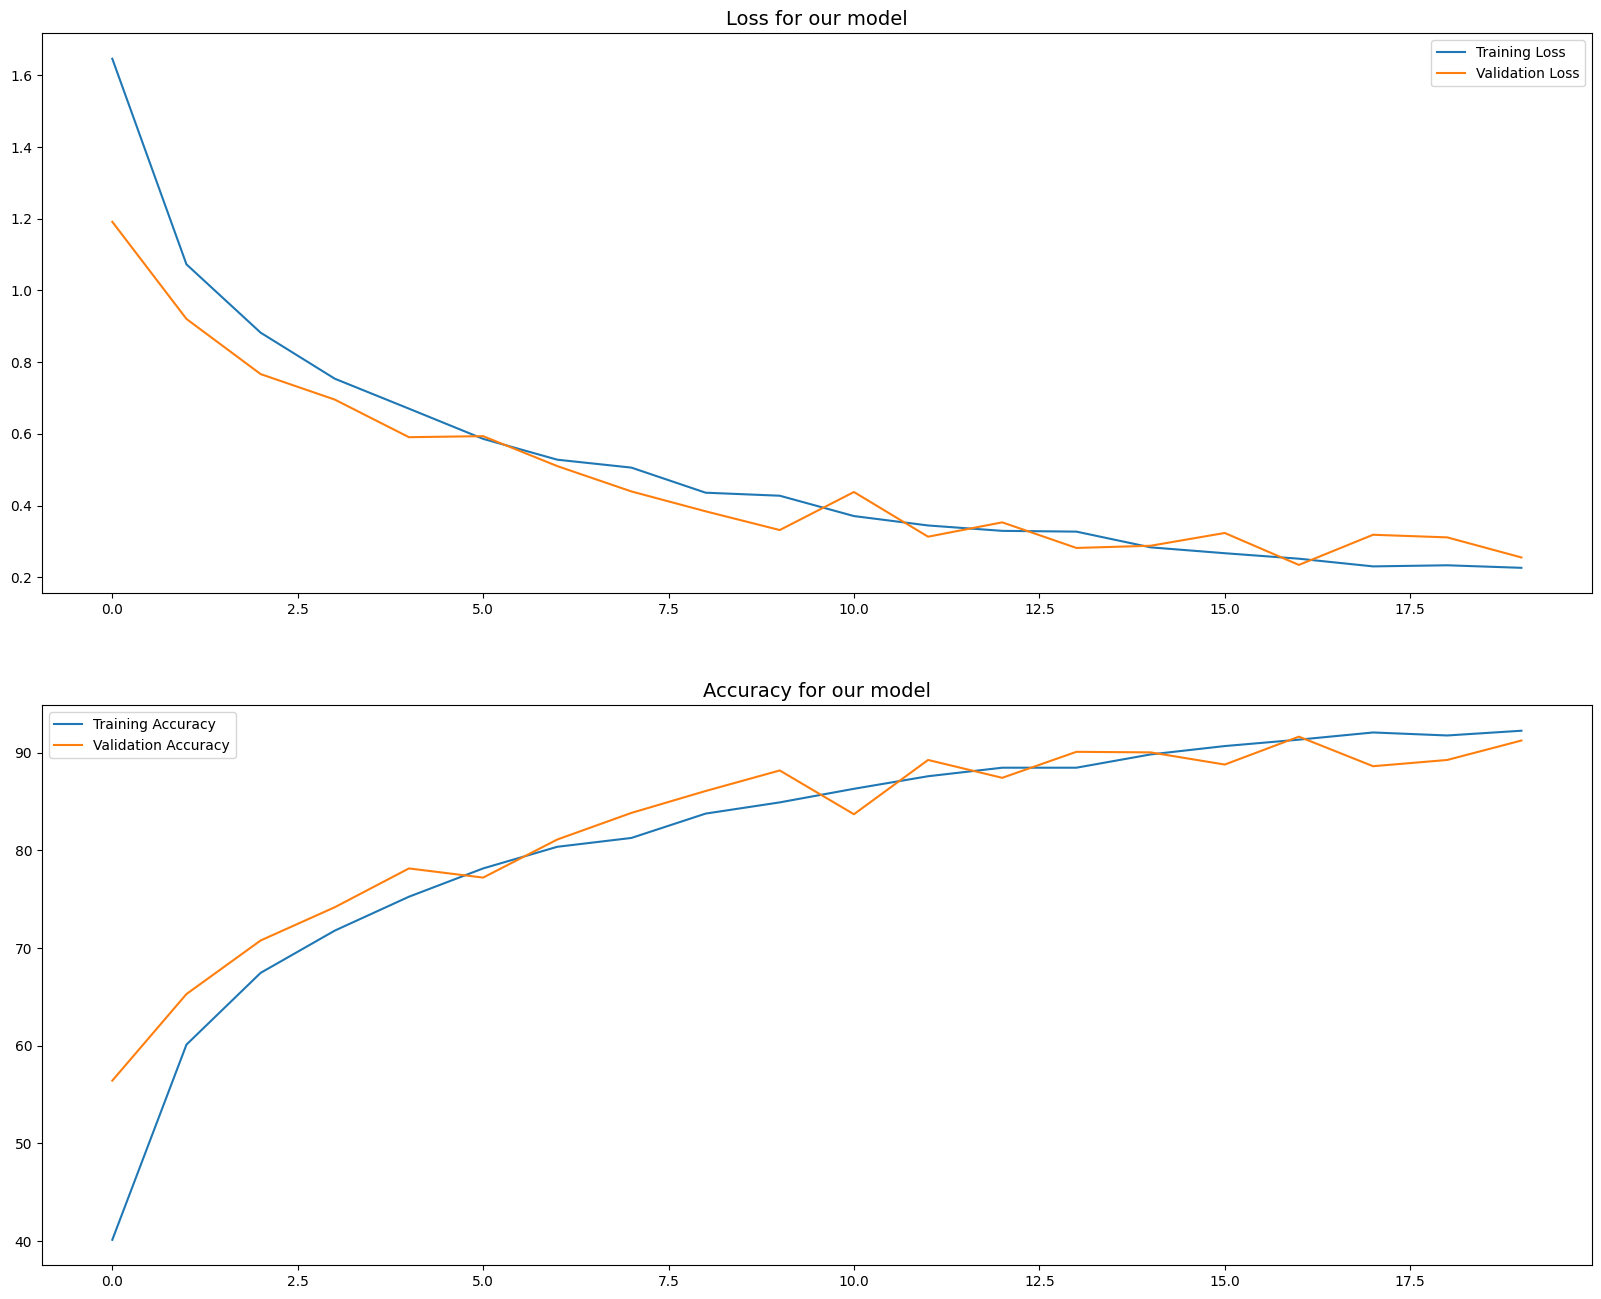

In [21]:
fig = plt.figure(num=2, figsize=(20, 16))  
fig1 = fig.add_subplot(2, 1, 1)
fig2 = fig.add_subplot(2, 1, 2)

fig1.plot(total_loss_train, label='Training Loss')
fig1.plot(total_loss_val, label='Validation Loss')
fig1.set_title('Loss for our model', fontsize=14)  
fig1.legend()
fig2.plot(total_acc_train, label='Training Accuracy')
fig2.plot(total_acc_val, label='Validation Accuracy')
fig2.set_title('Accuracy for our model', fontsize=14)  
fig2.legend()
plt.show()

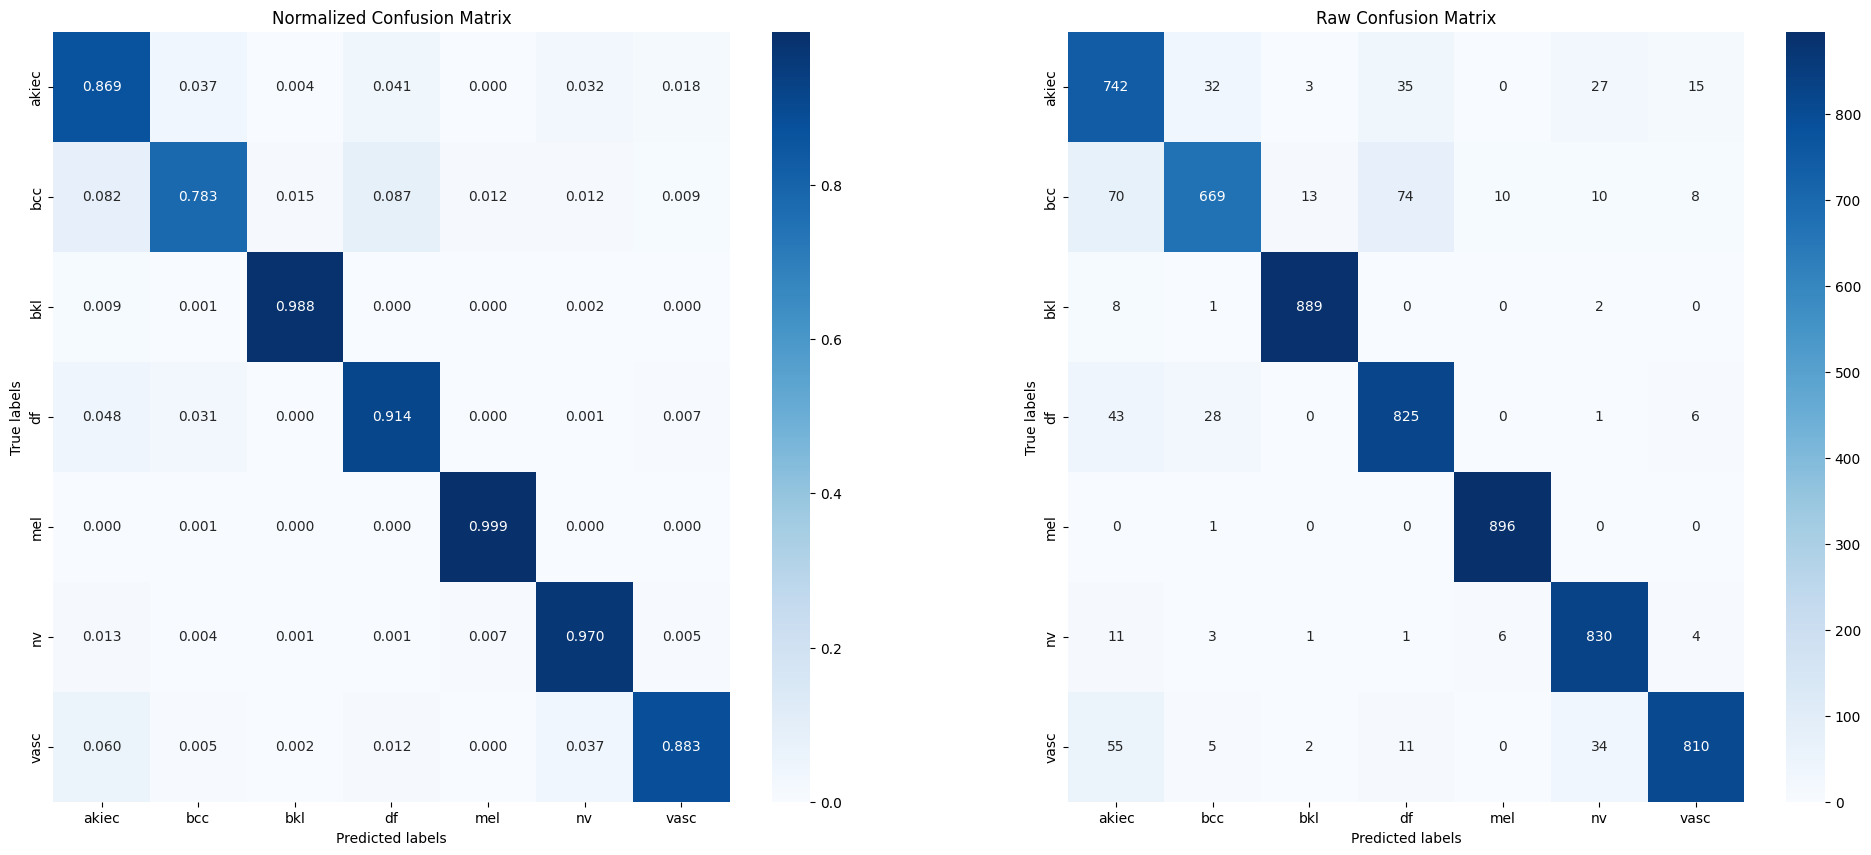

-------------------------------------------------------
Classification Report:

              precision    recall  f1-score   support

       akiec       0.80      0.87      0.83       854
         bcc       0.91      0.78      0.84       854
         bkl       0.98      0.99      0.98       900
          df       0.87      0.91      0.89       903
         mel       0.98      1.00      0.99       897
          nv       0.92      0.97      0.94       856
        vasc       0.96      0.88      0.92       917

    accuracy                           0.92      6181
   macro avg       0.92      0.92      0.91      6181
weighted avg       0.92      0.92      0.92      6181

-------------------------------------------------------


In [23]:
Model_functions.conf_report(CNN_model, test_loader, 'CNN_from_scratch')

In [29]:
# Test the model
# best_model_state = torch.load('CNN_model.pth')
# CNN_model_fitted.load_state_dict(best_model_state)
best_model_state = torch.load('CNN_model.pth', map_location='cpu')
CNN_model_fitted.load_state_dict(best_model_state)
CNN_model_fitted.to('cpu')
device = torch.device('cpu')
test_accuracy = Model_functions.test_model(CNN_model_fitted, test_loader, device)
print('-------------------------------------------------------')
print(f'Best models accuracy {test_accuracy}')
print('-------------------------------------------------------')

-------------------------------------------------------
Best models accuracy 91.81362239119883
-------------------------------------------------------
